In [1]:
# loading dataset & importing required libraries, modules and functions
import rfm_helpers as rh
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
import warnings

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 1000)
warnings.filterwarnings("ignore")

data = pd.read_excel("online_retail_II-230817-120704.xlsx", sheet_name="Year 2009-2010")
df = data.copy()

In [2]:
# checking data
rh.overview_df(df)

Shape: (525461, 8)
------------------------------------------------ Data Head ------------------------------------------------
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00   6.95     13085.00  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00   2.10     13085.00  United Kingdom
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24 2009-12-01 07:45:00   1.25     13085.00  United Kingdom
5  489434     22064           PINK DOUGHNUT TRINKET POT         24 2009-12-01 07:45:00   1.65     13085.00  United Kingdom
6  489434   

In [3]:
df = rh.preprocess_data(df)

Canceled transaction invoices have been removed.
Void transactions have been removed.
Stock codes of 'price: 0' have been removed.
#####################################################
              Invoice  Quantity    Price  Customer ID
StockCode                                            
ADJUST             32        32  3538.52           25
ADJUST2             3         3   731.05            3
BANK CHARGES       20        20   300.00           12
PADS               14        14     0.01           12
POST              738      2212 19964.83          230
TEST001            11        60    40.50            4
TEST002             1         1     1.00            1
#####################################################
Invalid stock codes have been removed: ['POST', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS', 'ADJUST', 'ADJUST2']
Preprocessing completed.


In [4]:
rh.overview_df(df, 5)

Shape: (406450, 8)
------------------------------------------------ Data Head ------------------------------------------------
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00   6.95     13085.00  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.00  United Kingdom
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00   2.10     13085.00  United Kingdom
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24 2009-12-01 07:45:00   1.25     13085.00  United Kingdom
------------------------------------------------ Data Tail ------------------------------------------------
       Invoice StockCode   

In [5]:
# recency
max_invoice_date = df["InvoiceDate"].max()
current_date = (max_invoice_date + dt.timedelta(days=2))

In [6]:
# monetary
df["TotalPrice"] = df["Quantity"]*df["Price"]

In [7]:
rfm = df.groupby("Customer ID").agg({"InvoiceDate": lambda date: (current_date-date.max()).days,
                                     "Invoice": "nunique",
                                     "TotalPrice": "sum"})

In [8]:
rfm.columns = ["Recency", "Frequency", "Monetary"]
rh.overview_df(rfm)

Shape: (4286, 3)
------------------------------------------------ Data Head ------------------------------------------------
             Recency  Frequency  Monetary
Customer ID                              
12346.00         166          2    169.36
12347.00           4          2   1323.32
12348.00          75          1    221.16
12349.00          44          2   2221.14
12351.00          12          1    300.93
12352.00          12          2    343.80
12353.00          45          1    317.76
12355.00         204          1    488.21
12356.00          17          3   3126.25
12357.00          25          1  11229.99
------------------------------------------------ Data Tail ------------------------------------------------
             Recency  Frequency  Monetary
Customer ID                              
18283.00          19          6    641.77
18284.00          68          1    461.68
18285.00         297          1    427.00
18286.00         113          2   1296.43
18287.00   

In [9]:
for col in rfm.columns:
    print(col, rh.check_outlier(rfm, col))

Recency False
Frequency True
Monetary True


In [10]:
for col in rfm.columns:
    rh.replace_with_thresholds(rfm, col)

In [11]:
rh.missing_values(rfm)

Empty DataFrame
Columns: [n_missing, ratio]
Index: []


In [12]:
rfm.describe()

,Recency,Frequency,Monetary
count,4286.00,4286.00,4286.00
mean,91.56,4.11,1588.58
std,96.35,4.89,2523.16
min,2.00,1.00,1.55
25%,19.00,1.00,307.66
50%,53.00,2.00,702.25
75%,136.75,5.00,1703.98
max,375.00,31.00,15243.20


In [13]:
for col in rfm.columns:
    print(col, rh.check_outlier(rfm, col))

Recency False
Frequency False
Monetary False


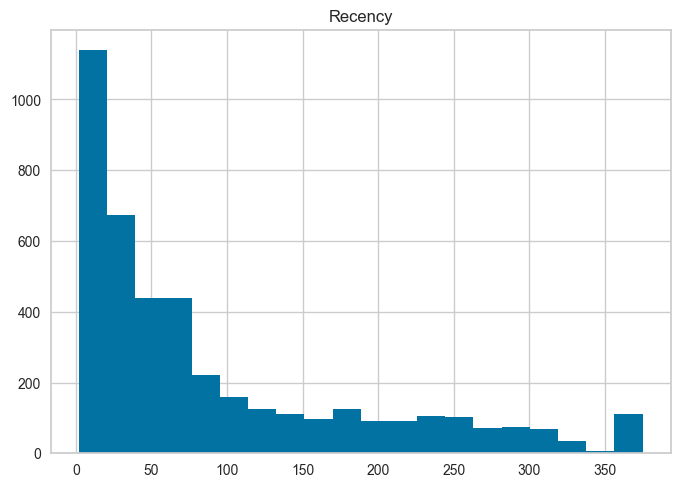

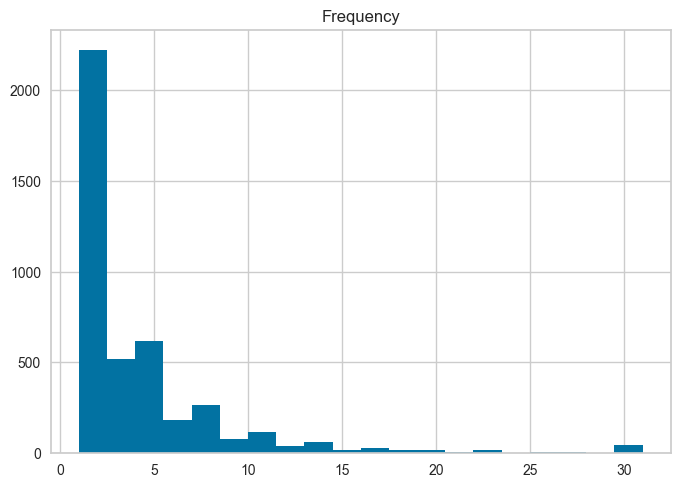

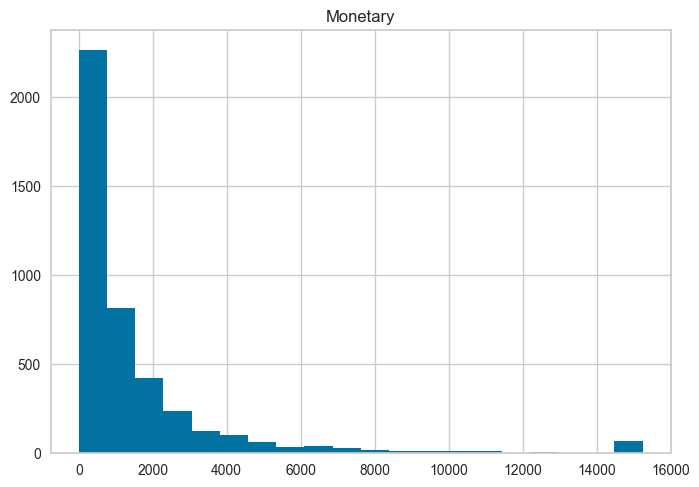

In [14]:
for col in rfm.columns:
    rfm[col].hist(bins=20)
    plt.title(f"{col}")
    plt.show()

In [15]:
# log transformation
for col in ["Recency", "Frequency"]:
    rfm[f"log{col}"] = np.log1p(rfm[col])

In [16]:
# checking rfm data
rh.overview_df(rfm)

Shape: (4286, 5)
------------------------------------------------ Data Head ------------------------------------------------
             Recency  Frequency  Monetary  logRecency  logFrequency
Customer ID                                                        
12346.00      166.00          2    169.36        5.12          1.10
12347.00        4.00          2   1323.32        1.61          1.10
12348.00       75.00          1    221.16        4.33          0.69
12349.00       44.00          2   2221.14        3.81          1.10
12351.00       12.00          1    300.93        2.56          0.69
12352.00       12.00          2    343.80        2.56          1.10
12353.00       45.00          1    317.76        3.83          0.69
12355.00      204.00          1    488.21        5.32          0.69
12356.00       17.00          3   3126.25        2.89          1.39
12357.00       25.00          1  11229.99        3.26          0.69
------------------------------------------------ Data Tail 

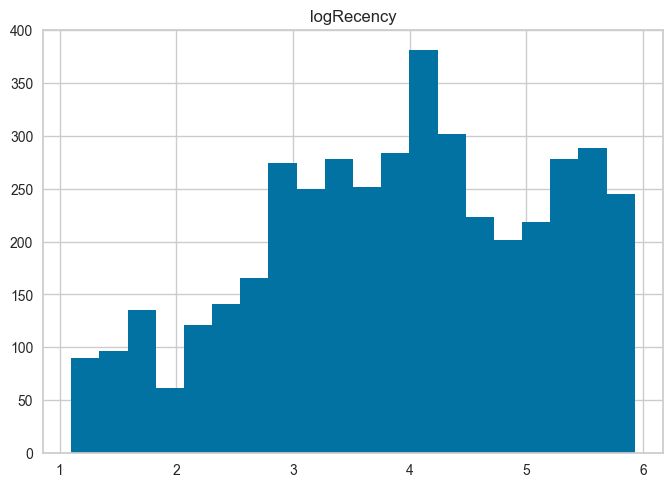

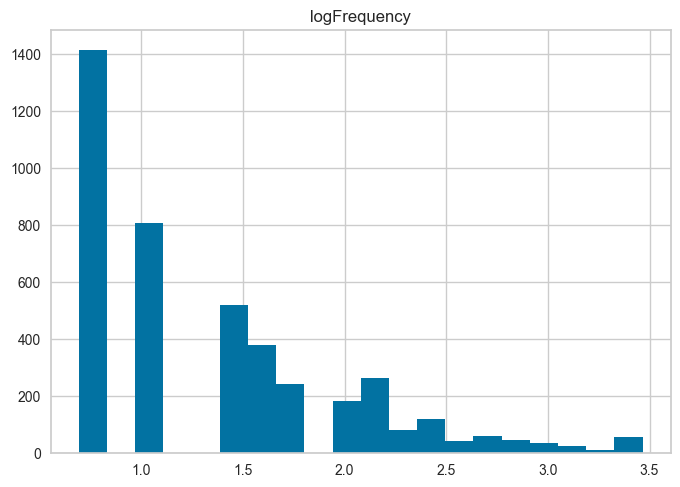

In [17]:
for col in ["logRecency", "logFrequency"]:
    rfm[col].hist(bins=20)
    plt.title(f"{col}")
    plt.show()

In [18]:
# standartization
scaled_rf = rh.standard_scaler(rfm, ["logRecency", "logFrequency"])
# scaled rfm dataframe
scaled_rff = pd.DataFrame(index=rfm.index, columns=["logRecency", "logFrequency"], data=scaled_rf)
scaled_rff.head()

,logRecency,logFrequency
Customer ID,,
12346.00,0.99,-0.40
12347.00,-1.85,-0.40
12348.00,0.35,-1.00
12349.00,-0.07,-0.40
12351.00,-1.08,-1.00


  File "C:\Users\SUDE\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\SUDE\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\SUDE\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\SUDE\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1493, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


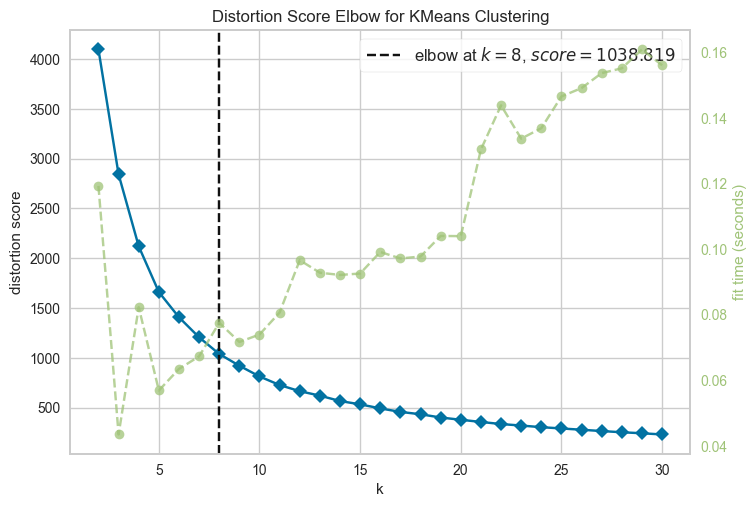

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=30)
elbow.fit(scaled_rff)
elbow.show()

In [20]:
# optimum value for cluster number
k_value = elbow.elbow_value_
print(k_value)

8


In [21]:
kmeans_ = KMeans(n_clusters=k_value).fit(scaled_rff)
segments = kmeans_.labels_
print(segments)

[2 3 1 ... 2 1 6]


In [22]:
rfm["kmeansSegments"] = segments+1
rfm.head()

,Recency,Frequency,Monetary,logRecency,logFrequency,kmeansSegments
Customer ID,,,,,,
12346.00,166.00,2,169.36,5.12,1.10,3
12347.00,4.00,2,1323.32,1.61,1.10,4
12348.00,75.00,1,221.16,4.33,0.69,2
12349.00,44.00,2,2221.14,3.81,1.10,2
12351.00,12.00,1,300.93,2.56,0.69,4


In [23]:
rfm["kmeansSegments"].value_counts()

3    955
2    819
5    629
7    535
4    459
8    366
1    342
6    181
Name: kmeansSegments, dtype: int64

In [24]:
kmeans_.n_clusters

8

In [25]:
# sum of squared distance to closest cluster center
kmeans_.inertia_

1043.2200910556364

In [26]:
kmeans_.cluster_centers_

array([[-1.65859328,  0.91154908],
       [ 0.21112371, -0.74464224],
       [ 1.25067717, -0.848319  ],
       [-0.87498742, -0.69584966],
       [ 0.55519757,  0.359438  ],
       [-1.63516125,  2.52322242],
       [-0.57978315,  0.35213641],
       [-0.38666665,  1.52040741]])

In [27]:
rfm.groupby("kmeansSegments").agg({"Recency": ["count", "mean", "median"],
                                   "Frequency": ["count", "mean", "median"],
                                   "Monetary": ["count", "mean", "median"]})

Recency               Frequency              Monetary                
                 count   mean median     count  mean median    count    mean  median
kmeansSegments                                                                      
1                  342   6.09   5.00       342  6.53   6.00      342 2308.01 1898.15
2                  819  66.97  64.00       819  1.43   1.00      819  532.56  375.81
3                  955 241.29 233.00       955  1.26   1.00      955  405.93  270.92
4                  459  18.17  18.00       459  1.51   2.00      459  520.14  369.97
5                  629 109.75  88.00       629  4.11   4.00      629 1658.52 1228.13
6                  181   6.76   5.00       181 21.09  19.00      181 8756.75 7403.95
7                  535  25.14  24.00       535  4.04   4.00      535 1499.19 1136.89
8                  366  35.55  29.00       366 10.26   9.00      366 4170.73 3138.99

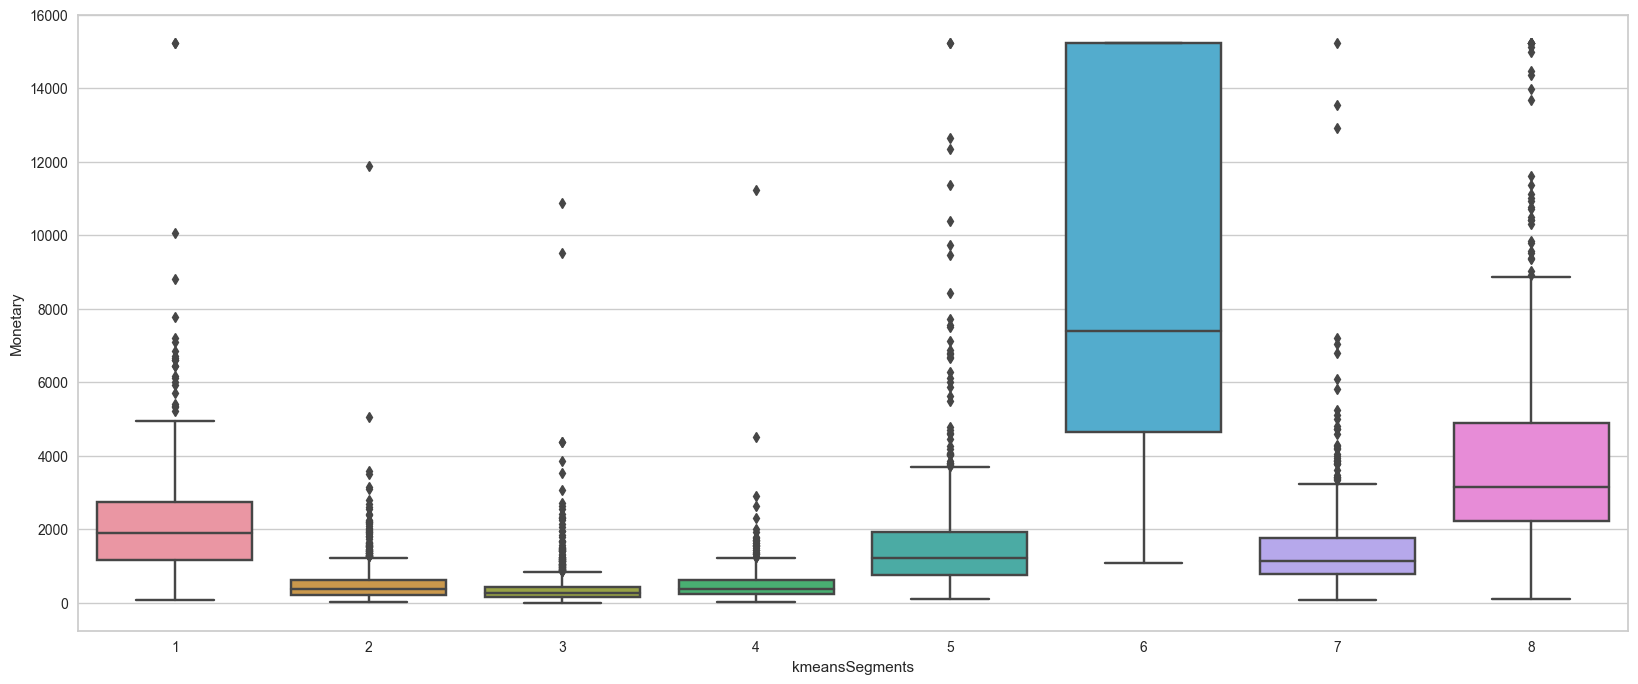

In [28]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="kmeansSegments", y="Monetary", data=rfm)
plt.show()

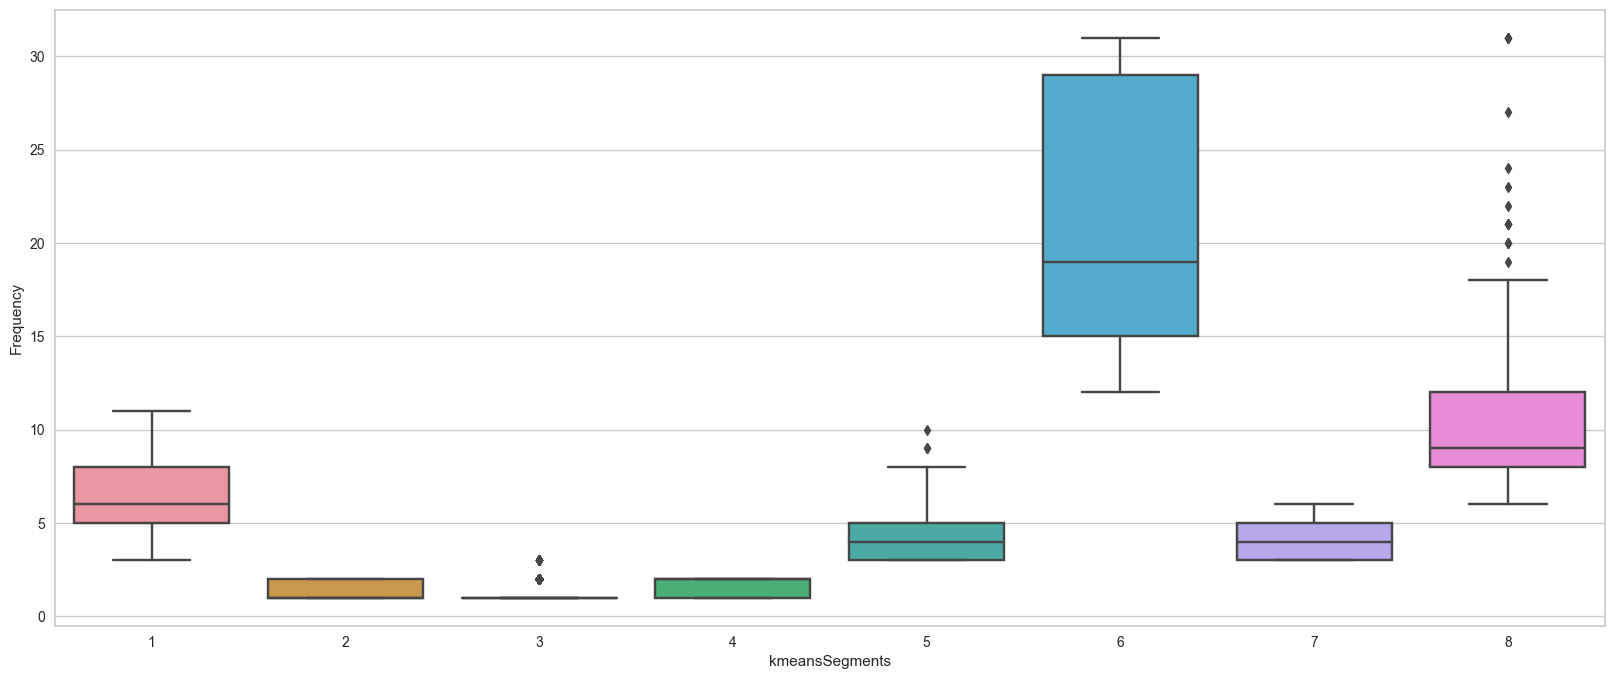

In [37]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="kmeansSegments", y="Frequency", data=rfm)
plt.show()

In [29]:
rfm.to_csv('kmeansClusters.csv')

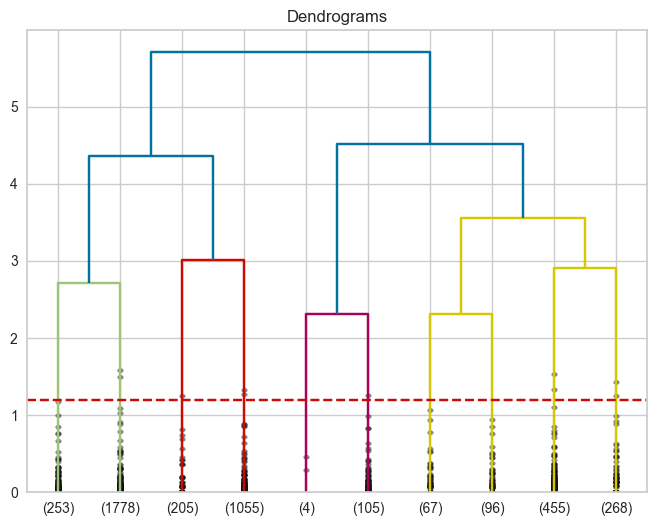

In [30]:
# hierarchical clustering
hc = linkage(scaled_rff, 'complete')
plt.figure(figsize=(8, 6))
plt.title("Dendrograms")
dend = dendrogram(hc,
                  truncate_mode="lastp",
                  p=10,
                  show_contracted=True,
                  leaf_font_size=10)
plt.axhline(y=1.2, color='r', linestyle='--')
plt.show()

In [31]:
ac = AgglomerativeClustering(n_clusters=6)
segments = ac.fit_predict(scaled_rff)
rfm["HierarchySegments"] = segments+1
rfm.head()

,Recency,Frequency,Monetary,logRecency,logFrequency,kmeansSegments,HierarchySegments
Customer ID,,,,,,,
12346.00,166.00,2,169.36,5.12,1.10,3,3
12347.00,4.00,2,1323.32,1.61,1.10,4,4
12348.00,75.00,1,221.16,4.33,0.69,2,5
12349.00,44.00,2,2221.14,3.81,1.10,2,2
12351.00,12.00,1,300.93,2.56,0.69,4,4


In [32]:
rfm.groupby("HierarchySegments").agg({"Recency": ["count", "mean", "median"],
                                      "Frequency": ["count", "mean", "median"],
                                      "Monetary": ["count", "mean", "median"]})

Recency               Frequency              Monetary                
                    count   mean median     count  mean median    count    mean  median
HierarchySegments                                                                      
1                     915  22.54  17.00       915  8.22   7.00      915 3183.45 2342.57
2                    1091  71.59  60.00      1091  3.42   3.00     1091 1354.29  940.86
3                    1131 227.53 220.00      1131  1.43   1.00     1131  474.46  301.65
4                     462  13.24  13.00       462  2.05   2.00      462  654.60  498.73
5                     534  55.18  53.50       534  1.00   1.00      534  413.07  281.32
6                     153   5.11   5.00       153 21.38  19.00      153 8880.06 7637.56

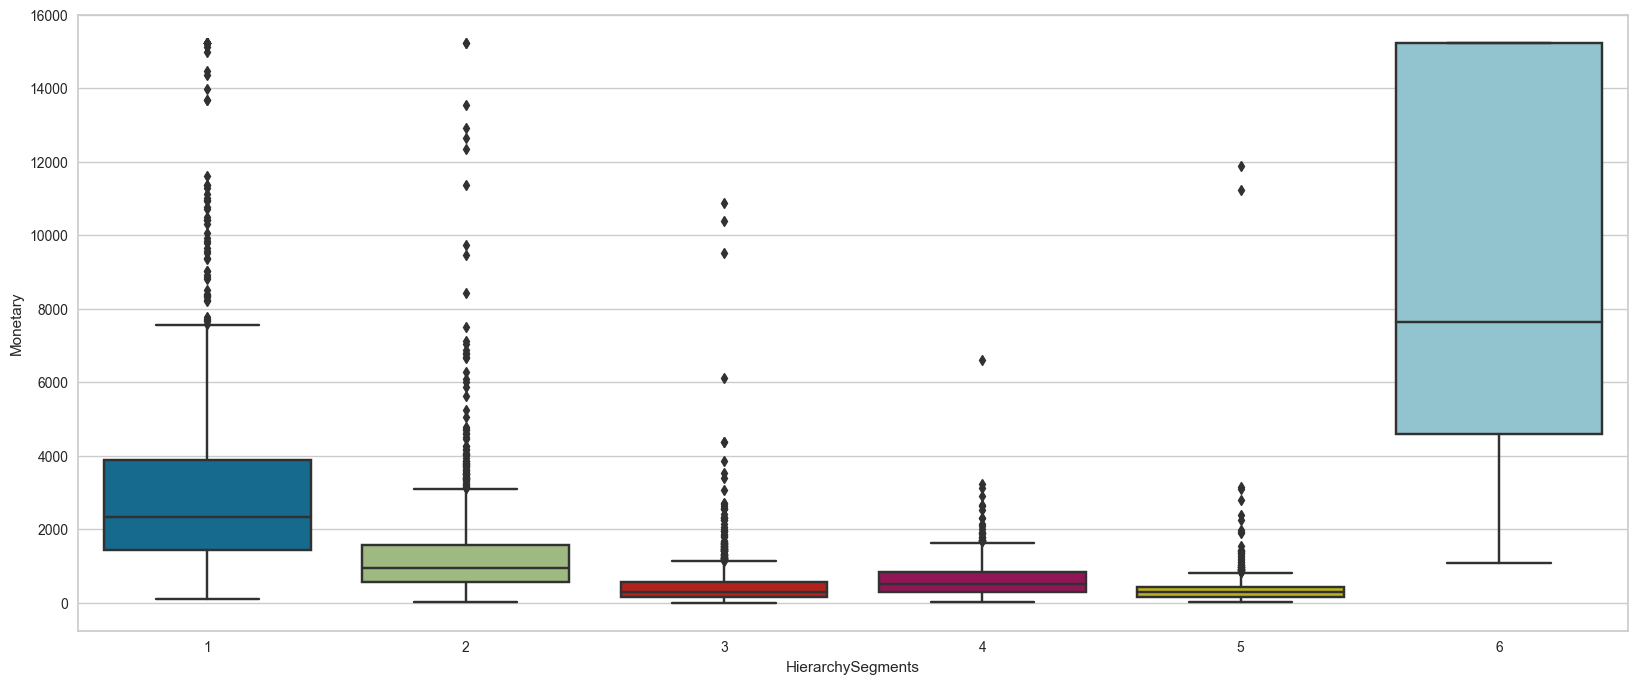

In [33]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="HierarchySegments", y="Monetary", data=rfm)
plt.show()

In [34]:
rh.overview_df(rfm, 5)

Shape: (4286, 7)
------------------------------------------------ Data Head ------------------------------------------------
             Recency  Frequency  Monetary  logRecency  logFrequency  kmeansSegments  HierarchySegments
Customer ID                                                                                           
12346.00      166.00          2    169.36        5.12          1.10               3                  3
12347.00        4.00          2   1323.32        1.61          1.10               4                  4
12348.00       75.00          1    221.16        4.33          0.69               2                  5
12349.00       44.00          2   2221.14        3.81          1.10               2                  2
12351.00       12.00          1    300.93        2.56          0.69               4                  4
------------------------------------------------ Data Tail ------------------------------------------------
             Recency  Frequency  Monetary  log